In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Data Loading and Preprocessing

In [34]:
# Load data
proteins = pd.read_csv('train_proteins.csv')
peptides = pd.read_csv('train_peptides.csv')
tclinical = pd.read_csv('train_clinical_data.csv')
supclinical = pd.read_csv('supplemental_clinical_data.csv')

In [35]:
proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [36]:
tclinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,6,NaN,NaN
1,55_3,55,3,10.0,7.0,19,NaN,NaN
2,55_6,55,6,8.0,10.0,58,NaN,NaN
3,55_9,55,9,8.0,9.0,17,0.0,On
4,55_12,55,12,10.0,10.0,2,0.0,On


In [37]:
#Some feature engineering

def transform_clinical(df):
    ##Get the change in UPDRS scores over time
    df.insert(4, "delta_updrs1", df.groupby(['patient_id'])['updrs_1'].diff())
    df.insert(6, "delta_updrs2", df.groupby(['patient_id'])['updrs_2'].diff())
    df.insert(8, "delta_updrs3", df.groupby(['patient_id'])['updrs_3'].diff())
    df.insert(10, "delta_updrs4", df.groupby(['patient_id'])['updrs_4'].diff())
    for i in [4, 6, 8, 10]:
        df.iloc[:, i].fillna(0, inplace=True)
    
    
    ##Add categorical labels for UPDRS scores
    # Define the bins for each UPDRS score
    bins_updrs1 = [0, 10, float('inf')]
    bins_updrs2 = [0, 12, float('inf')]
    bins_updrs3 = [0, 32, float('inf')]
    bins_updrs4 = [0, 4, float('inf')]

    # Define the labels for each bin
    labels = ['mild', 'mod/severe']

    # Create a new column 'y' for each UPDRS score with categorical labels
    df.insert(3, "cat_u1", pd.cut(df['updrs_1'], bins_updrs1, labels=labels))
    df.insert(6, "cat_u2", pd.cut(df['updrs_2'], bins_updrs2, labels=labels))
    df.insert(9, "cat_u3", pd.cut(df['updrs_3'], bins_updrs3, labels=labels))
    df.insert(12, "cat_u4", pd.cut(df['updrs_4'], bins_updrs4, labels=labels))
    for i in [3, 6, 9, 12]:
        df.iloc[:, i].fillna('mild', inplace=True)
    
    return df



tclinical = tclinical.rename(columns={'upd23b_clinical_state_on_medication': 'medication'})
tclinical["medication"].fillna('Off', inplace=True)
tclinical["medication"] = tclinical["medication"].astype('category')
transform_clinical(tclinical)

,visit_id,patient_id,visit_month,cat_u1,updrs_1,delta_updrs1,cat_u2,updrs_2,delta_updrs2,cat_u3,updrs_3,delta_updrs3,cat_u4,updrs_4,delta_updrs4,medication
0,55_0,55,0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
1,55_3,55,3,mild,10.0,0.0,mild,7.0,1.0,mild,19,13.0,mild,NaN,0.0,Off
2,55_6,55,6,mild,8.0,-2.0,mild,10.0,3.0,mod/severe,58,39.0,mild,NaN,0.0,Off
3,55_9,55,9,mild,8.0,0.0,mild,9.0,-1.0,mild,17,-41.0,mild,0.0,0.0,On
4,55_12,55,12,mild,10.0,2.0,mild,10.0,1.0,mild,2,-15.0,mild,0.0,0.0,On
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off
2611,65043_54,65043,54,mild,4.0,-3.0,mild,8.0,2.0,mod/severe,55,4.0,mild,1.0,1.0,Off
2612,65043_60,65043,60,mild,6.0,2.0,mild,6.0,-2.0,mild,0,-55.0,mild,1.0,0.0,Off
2613,65043_72,65043,72,mild,3.0,-3.0,mild,9.0,3.0,mod/severe,58,58.0,mild,1.0,0.0,Off


In [38]:
#first 6 patients 
patients = tclinical['patient_id'].unique()[:6]

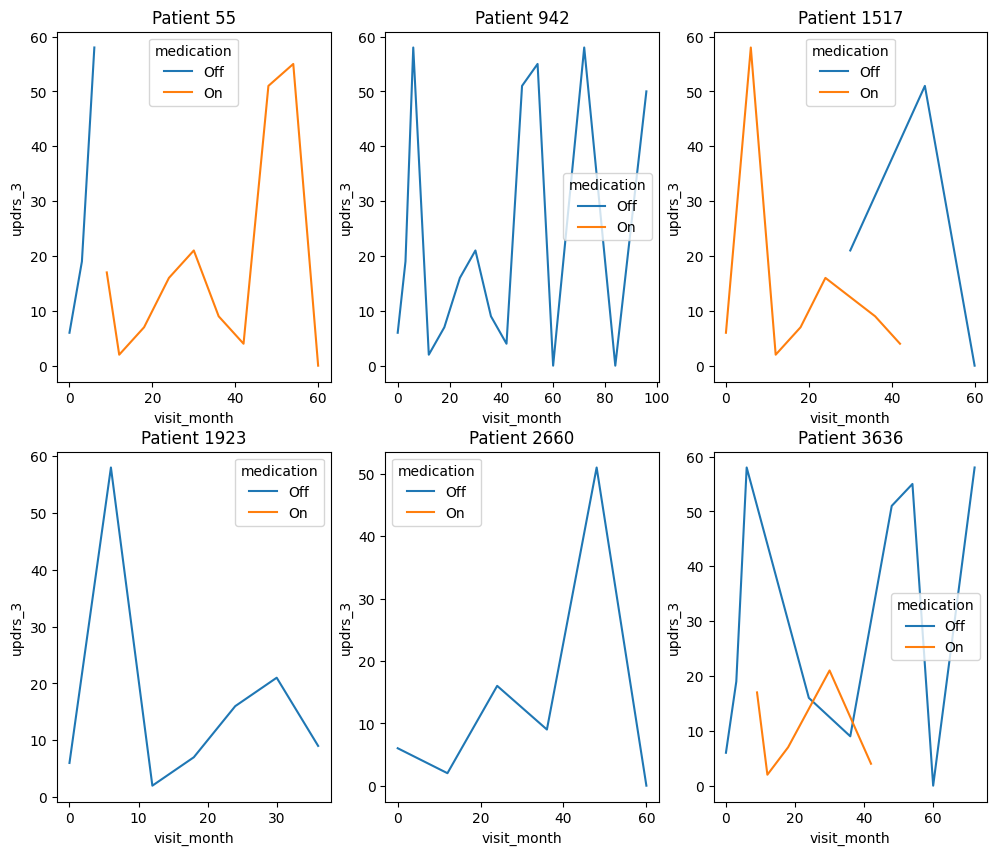

In [39]:
#do the same as above for the first 6 patients
plt.figure(figsize=(12, 10))
plt.subplot(2, 3, 1)
sns.lineplot(x='visit_month', y='updrs_3',hue='medication', data=tclinical[tclinical['patient_id'] == patients[0]])
plt.title(f'Patient {patients[0]}')
plt.subplot(2, 3, 2)
sns.lineplot(x='visit_month', y='updrs_3',hue='medication', data=tclinical[tclinical['patient_id'] == patients[1]])
plt.title(f'Patient {patients[1]}')
plt.subplot(2, 3, 3)
sns.lineplot(x='visit_month', y='updrs_3',hue='medication', data=tclinical[tclinical['patient_id'] == patients[2]])
plt.title(f'Patient {patients[2]}')
plt.subplot(2, 3, 4)
sns.lineplot(x='visit_month', y='updrs_3',hue='medication', data=tclinical[tclinical['patient_id'] == patients[3]])
plt.title(f'Patient {patients[3]}')
plt.subplot(2, 3, 5)
sns.lineplot(x='visit_month', y='updrs_3',hue='medication', data=tclinical[tclinical['patient_id'] == patients[4]])
plt.title(f'Patient {patients[4]}')
plt.subplot(2, 3, 6)
sns.lineplot(x='visit_month', y='updrs_3',hue='medication', data=tclinical[tclinical['patient_id'] == patients[5]])
plt.title(f'Patient {patients[5]}')
plt.show()




In [40]:
tclinical[tclinical["patient_id"] == 1517]

,visit_id,patient_id,visit_month,cat_u1,updrs_1,delta_updrs1,cat_u2,updrs_2,delta_updrs2,cat_u3,updrs_3,delta_updrs3,cat_u4,updrs_4,delta_updrs4,medication
28,1517_0,1517,0,mod/severe,11.0,0.0,mild,6.0,0.0,mild,6,0.0,mod/severe,5.0,0.0,On
29,1517_6,1517,6,mod/severe,17.0,6.0,mild,4.0,-2.0,mod/severe,58,52.0,mod/severe,7.0,2.0,On
30,1517_12,1517,12,mod/severe,20.0,3.0,mild,11.0,7.0,mild,2,-56.0,mod/severe,5.0,-2.0,On
31,1517_18,1517,18,mod/severe,23.0,3.0,mod/severe,14.0,3.0,mild,7,5.0,mod/severe,5.0,0.0,On
32,1517_24,1517,24,mod/severe,19.0,-4.0,mild,11.0,-3.0,mild,16,9.0,mild,3.0,-2.0,On
33,1517_30,1517,30,mod/severe,20.0,1.0,mod/severe,15.0,4.0,mild,21,5.0,mod/severe,10.0,7.0,Off
34,1517_36,1517,36,mod/severe,20.0,0.0,mod/severe,17.0,2.0,mild,9,-12.0,mod/severe,8.0,-2.0,On
35,1517_42,1517,42,mod/severe,15.0,-5.0,mod/severe,13.0,-4.0,mild,4,-5.0,mild,4.0,-4.0,On
36,1517_48,1517,48,mod/severe,20.0,5.0,mod/severe,18.0,5.0,mod/severe,51,47.0,mod/severe,6.0,2.0,Off
37,1517_60,1517,60,mod/severe,19.0,-1.0,mod/severe,18.0,0.0,mild,0,-51.0,mod/severe,10.0,4.0,Off


In [41]:
tclinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   visit_id      2615 non-null   object  
 1   patient_id    2615 non-null   int64   
 2   visit_month   2615 non-null   int64   
 3   cat_u1        2615 non-null   category
 4   updrs_1       2614 non-null   float64 
 5   delta_updrs1  2615 non-null   float64 
 6   cat_u2        2615 non-null   category
 7   updrs_2       2613 non-null   float64 
 8   delta_updrs2  2615 non-null   float64 
 9   cat_u3        2615 non-null   category
 10  updrs_3       2615 non-null   int64   
 11  delta_updrs3  2615 non-null   float64 
 12  cat_u4        2615 non-null   category
 13  updrs_4       1577 non-null   float64 
 14  delta_updrs4  2615 non-null   float64 
 15  medication    2615 non-null   category
dtypes: category(5), float64(7), int64(3), object(1)
memory usage: 238.2+ KB


In [42]:
proteins_updrs = pd.merge(proteins, tclinical, on = "visit_id")
proteins_updrs.drop(["patient_id_y", "visit_month_y"], axis = 1, inplace = True)

In [43]:
#calculating the change in NPX for each protein in relation to the previous month

# sort the DataFrame by visit month and UniProt
proteins_updrs.sort_values(['patient_id_x','UniProt', 'visit_month_x'], inplace=True)
proteins_updrs.insert(5, "delta_NPX", proteins_updrs.groupby(['patient_id_x', 'UniProt'])['NPX'].diff())
proteins_updrs.iloc[:, 5].fillna(0, inplace=True)
proteins_updrs.sort_values(['patient_id_x', "visit_month_x"], inplace=True)     #sort back to normal order

In [44]:
proteins_updrs

,visit_id,visit_month_x,patient_id_x,UniProt,NPX,delta_NPX,cat_u1,updrs_1,delta_updrs1,cat_u2,updrs_2,delta_updrs2,cat_u3,updrs_3,delta_updrs3,cat_u4,updrs_4,delta_updrs4,medication
0,55_0,0,55,O00391,11254.3,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
1,55_0,0,55,O00533,732430.0,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
2,55_0,0,55,O00584,39585.8,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
3,55_0,0,55,O14498,41526.9,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
4,55_0,0,55,O14773,31238.0,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193514,65043_48,48,65043,Q9UBX5,48796.4,-17773.5,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off
193515,65043_48,48,65043,Q9UHG2,320821.0,19873.0,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off
193516,65043_48,48,65043,Q9UKV8,39046.7,2896.3,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off
193517,65043_48,48,65043,Q9Y646,20198.8,-1087.5,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off


In [45]:
peptides_updrs = pd.merge(peptides, tclinical, on = "visit_id")
peptides_updrs.drop(["patient_id_y", "visit_month_y"], axis = 1, inplace = True)

#calculating the change in PeptideAbundance for each protein in relation to the previous month
# sort the DataFrame by visit month and UniProt
peptides_updrs.sort_values(['patient_id_x','Peptide', 'visit_month_x'], inplace=True)
peptides_updrs.insert(6, "delta_PA", peptides_updrs.groupby(['patient_id_x', 'Peptide'])['PeptideAbundance'].diff())
peptides_updrs.iloc[:, 6].fillna(0, inplace=True)
peptides_updrs.sort_values(['patient_id_x', "visit_month_x", "UniProt"], inplace=True)     #sort back to normal order

In [46]:
peptides_updrs

,visit_id,visit_month_x,patient_id_x,UniProt,Peptide,PeptideAbundance,delta_PA,cat_u1,updrs_1,delta_updrs1,cat_u2,updrs_2,delta_updrs2,cat_u3,updrs_3,delta_updrs3,cat_u4,updrs_4,delta_updrs4,medication
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,0.0,mild,10.0,0.0,mild,6.0,0.0,mild,6,0.0,mild,NaN,0.0,Off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815469,65043_48,48,65043,Q9UHG2,ILAGSADSEGVAAPR,185566.0,17830.0,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off
815470,65043_48,48,65043,Q9UKV8,SGNIPAGTTVDTK,39046.7,2896.3,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off
815471,65043_48,48,65043,Q9Y646,LALLVDTVGPR,20198.8,-1087.5,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off
815472,65043_48,48,65043,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,11124.1,-2822.0,mild,7.0,-2.0,mild,6.0,-4.0,mod/severe,51,47.0,mild,0.0,0.0,Off


### New DF for PCA or PLS-DA. Protein/Peptides only 

In [47]:
prot_pivot = proteins_updrs.pivot(index='visit_id', columns='UniProt', values='NPX')


In [48]:
order = proteins_updrs["visit_id"].unique()
#reorder the rows using the order list
prot_pivot = prot_pivot.reindex(order)

In [49]:
#impute missing values by replacing any NaN with the mean of the column
prot_pivot.fillna(0, inplace=True)

In [75]:
peptides_pivot = peptides_updrs.pivot(index='visit_id', columns='Peptide', values='PeptideAbundance')
order = peptides_updrs["visit_id"].unique()
peptides_pivot = peptides_pivot.reindex(order)
peptides_pivot.fillna(0, inplace=True)

In [50]:
delta_prot_pivot = proteins_updrs.pivot(index='visit_id', columns='UniProt', values='delta_NPX')
delta_prot_pivot = delta_prot_pivot.reindex(order)
#delta_prot_pivot.fillna(delta_prot_pivot.mean(), inplace=True)
delta_prot_pivot.fillna(0, inplace=True)


In [76]:
delta_peptides_pivot = peptides_updrs.pivot(index='visit_id', columns='Peptide', values='delta_PA')
delta_peptides_pivot = delta_peptides_pivot.reindex(order)
delta_peptides_pivot.fillna(0, inplace=True)


In [77]:
delta_peptides_pivot

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55_6,-704490.0,-8603.7,76150.0,0.0,4085.0,-23860.6,-7718.7,-7359.6,-59320.0,1481.8,...,-30079.0,-3293.50,309250.0,6491.0,-65806.0,-27643.0,-21244.0,20586.0,-6241.5,5805.5
55_12,102620.0,7749.0,339750.0,-4408.3,-6006.9,56772.6,7188.5,9272.6,-709740.0,-5868.4,...,60693.0,4675.00,1354620.0,2901.0,196954.0,33431.0,37156.0,-5638.0,14677.4,1137.2
55_36,2289110.0,5107.5,989780.0,6854.8,1559.8,-82955.9,3952.3,465105.0,1347720.0,9145.2,...,-46482.0,706.70,-2814480.0,-25349.1,-32652.0,-8350.0,21917.0,46368.0,-1932.4,-7867.4
942_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64674_84,-370890.0,4221.8,-328070.0,0.0,0.0,2801.4,0.0,-5458.7,-121610.0,-119.3,...,4723.0,687.52,554310.0,-10017.5,-55539.0,579.4,-6126.5,44502.0,490.6,-5688.8
65043_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65043_12,251760.0,-18500.3,3114260.0,-3223.1,21.9,-40570.0,-271.8,50885.0,176810.0,-2449.7,...,-26924.0,-1613.40,-33100.0,-7039.6,13146.0,3680.0,3659.0,-6288.0,-3055.1,8107.4


In [51]:
#concatenate the two pivot tables
ppdel = pd.merge(prot_pivot, delta_prot_pivot, on = "visit_id", suffixes=["_prot", "_delta"])

#reorder the columns
ppdel = ppdel.reindex(sorted(ppdel.columns), axis=1)

In [52]:
#get the value of updrs1 at each unique id (order)
updrs1 = proteins_updrs.groupby("visit_id")["cat_u1"].first().reindex(order)
updrs2 = proteins_updrs.groupby("visit_id")["cat_u2"].first().reindex(order)
updrs3 = proteins_updrs.groupby("visit_id")["cat_u3"].first().reindex(order)
updrs4 = proteins_updrs.groupby("visit_id")["cat_u4"].first().reindex(order)

<Axes: ylabel='UniProt'>

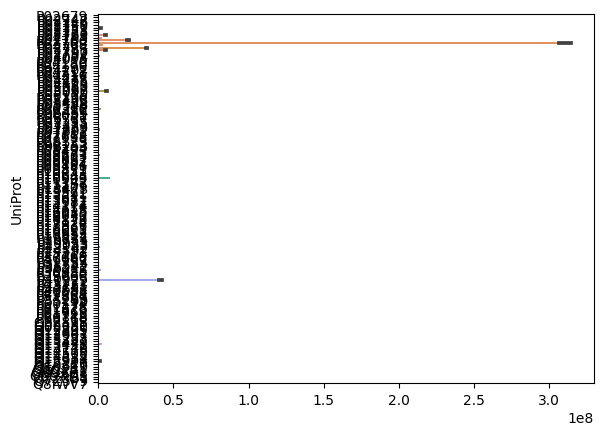

In [53]:
#Checking for outliers
sns.barplot(data=prot_pivot.iloc[:, 55:200], orient="h")

<Axes: ylabel='UniProt'>

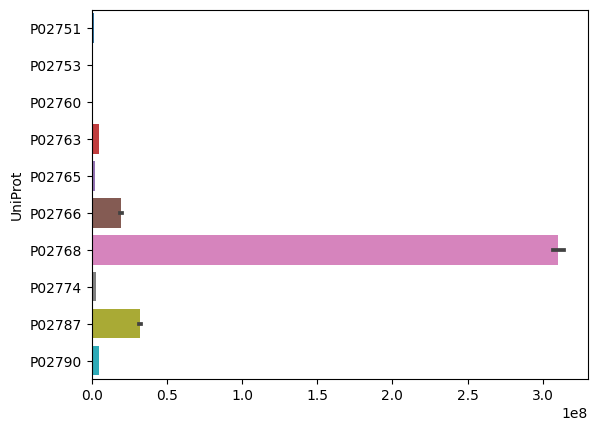

In [54]:
#Checking for outliers
sns.barplot(data=prot_pivot.iloc[:, 60:70], orient="h")

In [55]:
### remove outliers

#proteins_updrs_pivot = proteins_updrs_pivot[(np.abs(stats.zscore(proteins_updrs_pivot)) < 3).all(axis=1)] # remove outliers
#z_scores_df = (prot_pivot - prot_pivot.mean()) / prot_pivot.std(ddof=0)                                    # zscore df

#prot_pivot_no_albumin = prot_pivot.drop(columns=['P02768'])                     # remove albumin#drop P02768 from prot_pivot


In [56]:
updrs1

visit_id
55_0              mild
55_6              mild
55_12             mild
55_36       mod/severe
942_6             mild
               ...    
64674_84    mod/severe
65043_0           mild
65043_12          mild
65043_24          mild
65043_48          mild
Name: cat_u1, Length: 1068, dtype: category
Categories (2, object): ['mild' < 'mod/severe']

In [57]:

scaler = StandardScaler()

map_dict = {'mild': 1, 'mod/severe': 2}
reverse_map_dict = {1: 'mild', 2: 'mod/severe'}

u1 = updrs1.map(map_dict)
u2 = updrs2.map(map_dict)
u3 = updrs3.map(map_dict)
u4 = updrs4.map(map_dict)


Variance explained by each component:  [52.48621542  2.88588425]


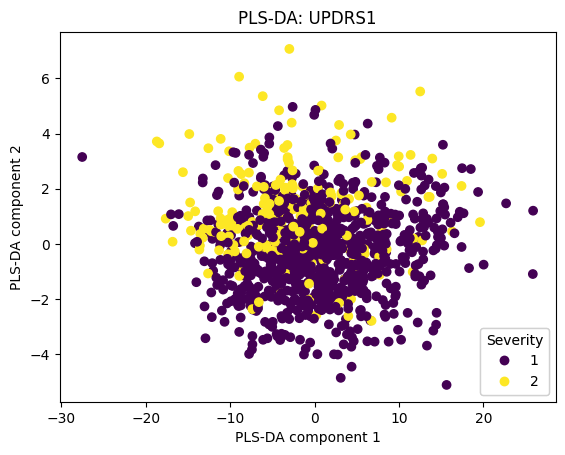

In [58]:
n_components = 2
plsda = PLSRegression(n_components=n_components)

plsda.fit(scaler.fit_transform(prot_pivot), u1)

#variance explained by each component
print('Variance explained by each component: ', plsda.x_scores_.var(axis=0))

fig, ax = plt.subplots()
scatter = ax.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u1, cmap='viridis')
ax.set_xlabel('PLS-DA component 1')
ax.set_ylabel('PLS-DA component 2')
ax.set_title('PLS-DA: UPDRS1')

#show legend
legend1 = ax.legend(*scatter.legend_elements(), loc="lower right", title="Severity")
ax.add_artist(legend1)

In [59]:
plsda.x_scores_.var(axis=0)[1]

2.8858842543591074

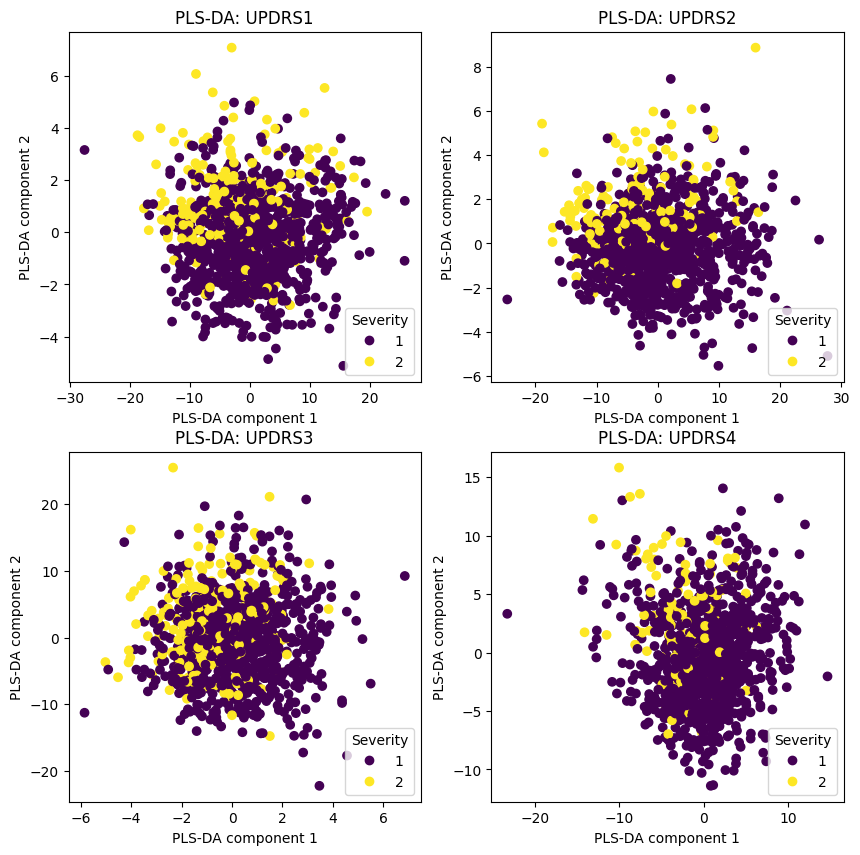

In [60]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plsda.fit(scaler.fit_transform(prot_pivot), u1)
plt.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u1, cmap='viridis')
plt.xlabel('PLS-DA component 1')
plt.ylabel('PLS-DA component 2')
plt.title('PLS-DA: UPDRS1')
plt.legend(*scatter.legend_elements(), loc="lower right", title="Severity")


plt.subplot(2, 2, 2)
plsda.fit(scaler.fit_transform(prot_pivot), u2)
plt.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u2, cmap='viridis')
plt.xlabel('PLS-DA component 1')
plt.ylabel('PLS-DA component 2')
plt.title('PLS-DA: UPDRS2')
plt.legend(*scatter.legend_elements(), loc="lower right", title="Severity")


plt.subplot(2, 2, 3)
plsda.fit(scaler.fit_transform(prot_pivot), u3)
plt.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u3, cmap='viridis')
plt.xlabel('PLS-DA component 1')
plt.ylabel('PLS-DA component 2')
plt.title('PLS-DA: UPDRS3')
plt.legend(*scatter.legend_elements(), loc="lower right", title="Severity")


plt.subplot(2, 2, 4)
plsda.fit(scaler.fit_transform(prot_pivot), u4)
plt.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u4, cmap='viridis')
plt.xlabel('PLS-DA component 1')
plt.ylabel('PLS-DA component 2')
plt.title('PLS-DA: UPDRS4')
plt.legend(*scatter.legend_elements(), loc="lower right", title="Severity")


#show legend


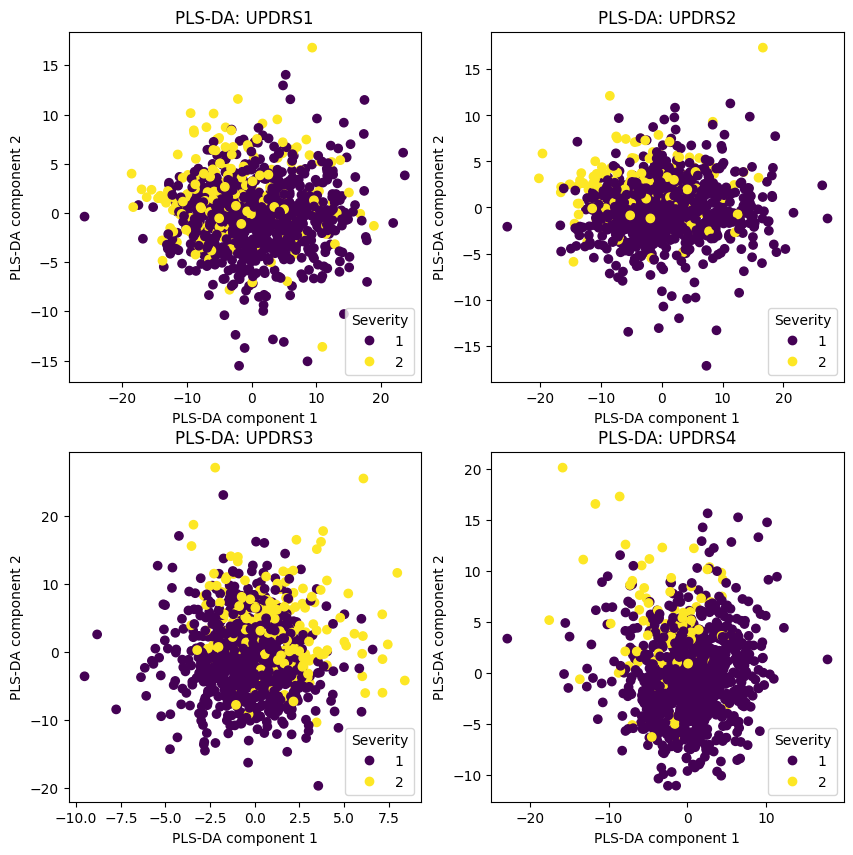

In [61]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plsda.fit(scaler.fit_transform(ppdel), u1)
plt.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u1, cmap='viridis')
plt.xlabel('PLS-DA component 1')
plt.ylabel('PLS-DA component 2')
plt.title('PLS-DA: UPDRS1')
plt.legend(*scatter.legend_elements(), loc="lower right", title="Severity")


plt.subplot(2, 2, 2)
plsda.fit(scaler.fit_transform(ppdel), u2)
plt.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u2, cmap='viridis')
plt.xlabel('PLS-DA component 1')
plt.ylabel('PLS-DA component 2')
plt.title('PLS-DA: UPDRS2')
plt.legend(*scatter.legend_elements(), loc="lower right", title="Severity")


plt.subplot(2, 2, 3)
plsda.fit(scaler.fit_transform(ppdel), u3)
plt.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u3, cmap='viridis')
plt.xlabel('PLS-DA component 1')
plt.ylabel('PLS-DA component 2')
plt.title('PLS-DA: UPDRS3')
plt.legend(*scatter.legend_elements(), loc="lower right", title="Severity")


plt.subplot(2, 2, 4)
plsda.fit(scaler.fit_transform(ppdel), u4)
plt.scatter(plsda.x_scores_[:, 0], plsda.x_scores_[:, 1], c=u4, cmap='viridis')
plt.xlabel('PLS-DA component 1')
plt.ylabel('PLS-DA component 2')
plt.title('PLS-DA: UPDRS4')
plt.legend(*scatter.legend_elements(), loc="lower right", title="Severity")


#show legend


Text(0.5, 1.0, 'Correlation Matrix of UPDRS1, UPDRS2, UPDRS3, UPDRS4')

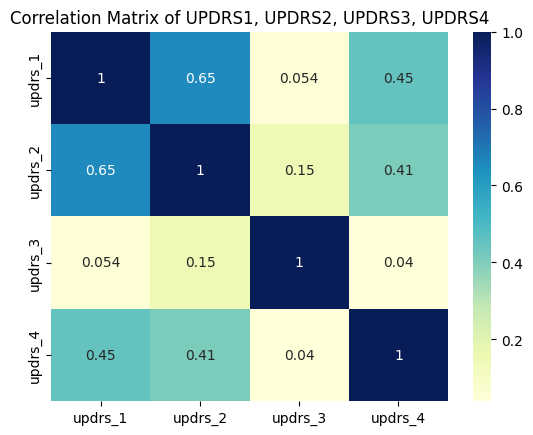

In [62]:
up1 = proteins_updrs.groupby("visit_id")["updrs_1"].first().reindex(order)
up2 = proteins_updrs.groupby("visit_id")["updrs_2"].first().reindex(order)
up3 = proteins_updrs.groupby("visit_id")["updrs_3"].first().reindex(order)
up4 = proteins_updrs.groupby("visit_id")["updrs_4"].first().reindex(order)

#correlation matrix of updrs1, updrs2, updrs3, updrs4
corr = pd.concat([up1, up2, up3, up4], axis=1).corr()
plot = sns.heatmap(corr, annot=True, cmap="YlGnBu")
plot.set_title("Correlation Matrix of UPDRS1, UPDRS2, UPDRS3, UPDRS4")


In [83]:
y = plsda.fit(scaler.fit_transform(ppdel), u3)
z = y.transform(scaler.fit_transform(ppdel))
z

In [63]:
#get the loadings and corresponding protein names of the second component of PLS-DA and updrs1
plsda.fit(scaler.fit_transform(prot_pivot), u1)
loadings_2 = plsda.x_loadings_[:, 1]


In [64]:
idx_sorted = np.argsort(np.abs(loadings_2))[::-1]
top40p_u1 = prot_pivot.columns[idx_sorted[:40,]]


In [65]:
top40p_u1

Index(['P43652', 'P02647', 'P02652', 'P01042', 'P00734', 'P00747', 'P02774',
       'P06727', 'P08697', 'P02656', 'O14791', 'Q96PD5', 'P04196', 'P01877',
       'Q13283', 'P01608', 'P01621', 'P02749', 'P06454', 'P01859', 'P24592',
       'P36980', 'P36955', 'Q9HDC9', 'P02675', 'P02765', 'Q562R1', 'P01033',
       'P51884', 'P27169', 'P01717', 'P01031', 'P04207', 'Q9UBX5', 'P04004',
       'Q92876', 'P60174', 'P06681', 'P07711', 'P16035'],
      dtype='object', name='UniProt')

In [66]:
#get the loadings and corresponding protein names of the second component of PLS-DA and updrs2
plsda.fit(scaler.fit_transform(prot_pivot), u2)
loadings_2 = plsda.x_loadings_[:, 1]
idx_sorted = np.argsort(np.abs(loadings_2))[::-1]
top40p_u2 = prot_pivot.columns[idx_sorted[:40,]]


In [67]:
top40p_u2

Index(['Q16270', 'P02766', 'P08294', 'P01344', 'P01009', 'P27169', 'P16035',
       'P25311', 'Q9Y6R7', 'P18065', 'P05090', 'P01033', 'P16070', 'P07225',
       'Q6UXB8', 'Q12841', 'P07998', 'Q7Z5P9', 'P61626', 'P19823', 'P36955',
       'P04275', 'Q8N2S1', 'P08603', 'P20774', 'P00441', 'P09486', 'P02763',
       'P51884', 'P10451', 'P05452', 'P05156', 'P61769', 'P08253', 'P61916',
       'P02649', 'P02750', 'P31997', 'P13987', 'P08637'],
      dtype='object', name='UniProt')

In [68]:
#check for overlap between top40p_u1 and top40p_u2
overlap = set(top40p_u1).intersection(top40p_u2)
overlap


{'P01033', 'P16035', 'P27169', 'P36955', 'P51884'}

In [69]:
#add top40p_u1 and top40p_u2 to a list with only unique values
top40p_u1_u2 = list(set(top40p_u1).union(top40p_u2))
len(top40p_u1_u2)


75

In [70]:
final_u1 = proteins_updrs.groupby("visit_id")["updrs_1"].first().reindex(order)
final_u2 = proteins_updrs.groupby("visit_id")["updrs_2"].first().reindex(order)
final_u3 = proteins_updrs.groupby("visit_id")["updrs_3"].first().reindex(order)
final_u4 = proteins_updrs.groupby("visit_id")["updrs_4"].first().reindex(order)

#concate the updrs1, updrs2, updrs3, updrs4 to a dataframe
proteins_only_ys = pd.concat([final_u1, final_u2, final_u3, final_u4], axis=1)

In [74]:
#make a new folder in this directory
from pathlib import Path
Path("AMP_Data").mkdir(parents=True, exist_ok=True)


In [87]:
#save tclinical data to csv to AMP_Data folder
proteins_only_ys.to_csv("AMP_Data/proteins_only_ys.csv", index=True)
tclinical.to_csv("AMP_Data/processed_tclinical.csv", index=True)
proteins_updrs.to_csv("AMP_Data/proteins_updrs.csv", index=True)
peptides_updrs.to_csv("AMP_Data/peptides_updrs.csv", index=True)
prot_pivot.to_csv("AMP_Data/prot_pivot.csv", index=True)
peptides_pivot.to_csv("AMP_Data/pep_pivot.csv", index=True)
delta_peptides_pivot.to_csv("AMP_Data/delta_pep_pivot.csv", index=True)
delta_prot_pivot.to_csv("AMP_Data/delta_prot_pivot.csv", index=True)